In [121]:
import sys
import os
import importlib

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

sys.path.append('../src/construct/')
import util
import annual_heat_demand

idx = pd.IndexSlice

data_path = '../data/'

In [22]:
importlib.reload(util)

<module 'util' from '../src/construct/util.py'>

In [ ]:
energy_balances = pd.read_csv('../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
subsectors = pd.read_csv(data_path + '/energy_balance_category_names.csv', index_col=0)
carriers = pd.read_csv(data_path + '/energy_balance_carrier_names.csv', index_col=0)
JRC_IDEES =  pd.read_csv(data_path + 'industry/JRC_IDEES_industry_end_use_consumption.csv', index_col=[0, 1, 2, 3, 4, 5], squeeze=True, header=0).rename(util.get_alpha3, level='country_code')
published_data = pd.read_csv(data_path + 'industry/published_industry_end_use_consumption.csv', index_col=[0, 1, 2, 3, 4], squeeze=True, header=0)

In [3]:
_carriers = {
    'H8000': 'heat', 
    'RA600': 'renewable_heat',
    'R5110-5150_W6000RI': 'biofuel',
    'R5160': 'biofuel',
    'R5300': 'natural_gas',
    'W6210': 'biofuel',
    'R5210P': 'oil',
    'R5210B': 'oil',
    'R5220P': 'oil',
    'R5220B': 'oil',
    '5230P': 'oil',
    'R5230B': 'oil',
    'R5290': 'oil',
    'RA100': 'renewable_heat',
    'RA500': 'renewable_heat',
    'RA300': 'renewable_heat',
    'RA420': 'renewable_heat',
    'RA410': 'renewable_heat',
    'RA200': 'renewable_heat',
    'E7000': 'electricity', 
    'C0350-0370': 'manufactured_gas', 
    'G3000': 'natural_gas',
    'O4000XBIO': 'oil', 
    'P1000': 'solid_fuel', 
    'S2000': 'oil', 
    'N900H': 'heat',
    'C0000X0350-0370': 'solid_fuel', 
    'W6100_6220': 'biofuel'
}

_subsectors = {
    'Chemical & petrochemical': 'Chemicals Industry',
    'Food, beverages & tobacco': 'Food, beverages and tobacco',
    'Iron & steel': 'Iron and steel',
    'Machinery': 'Machinery Equipment',
    'Non-ferrous metals': 'Non Ferrous Metals',
    'Non-metallic minerals': 'Non-metallic mineral products',
    'Not elsewhere specified (industry)': 'Other Industrial Sectors',
    'Mining & quarrying': 'Mining and quarrying',
    'Construction': 'Other Industrial Sectors',
    'Paper, pulp & printing': 'Pulp, paper and printing',
    'Textile & leather': 'Textiles and leather',
    'Transport equipment': 'Transport Equipment',
    'Wood & wood products': 'Wood and wood products',
}
countries = {i: util.get_alpha3(i) for i in energy_balances.index.levels[3]}
years = {i: int(i) for i in range(2000, 2019)}
cat_names = {k: _subsectors[v] if v in _subsectors.keys() else v for k, v in subsectors.sub_cat_2.fillna(subsectors.sub_cat_1).to_dict().items()}
#cat_names = {k: v if v not in ['Iron & Steel', 'Non-ferrous metals'] else 'Metals' for k, v in cat_names.items()}
industry_energy_balances = (
    energy_balances[energy_balances.index.get_level_values(0).str.contains(r'^FC_IND_')]
    .apply(util.tj_to_twh)
    .groupby(
        [cat_names, countries, years, _carriers],
        level=['cat_code', 'country', 'year', 'carrier_code']
    ).sum()
    .rename_axis(index=['cat_name', 'country_code', 'year', 'carrier_name'])
    .reorder_levels(['carrier_name', 'cat_name', 'country_code', 'year'])
)

non_energy = industry_energy_balances.xs('Non-energy use in industry sector', level='cat_name')
non_energy = non_energy[non_energy > 0].sum(level=['country_code', 'carrier_name', 'year']).unstack()

industry_energy_balances = industry_energy_balances.drop('Non-energy use in industry sector', level='cat_name')

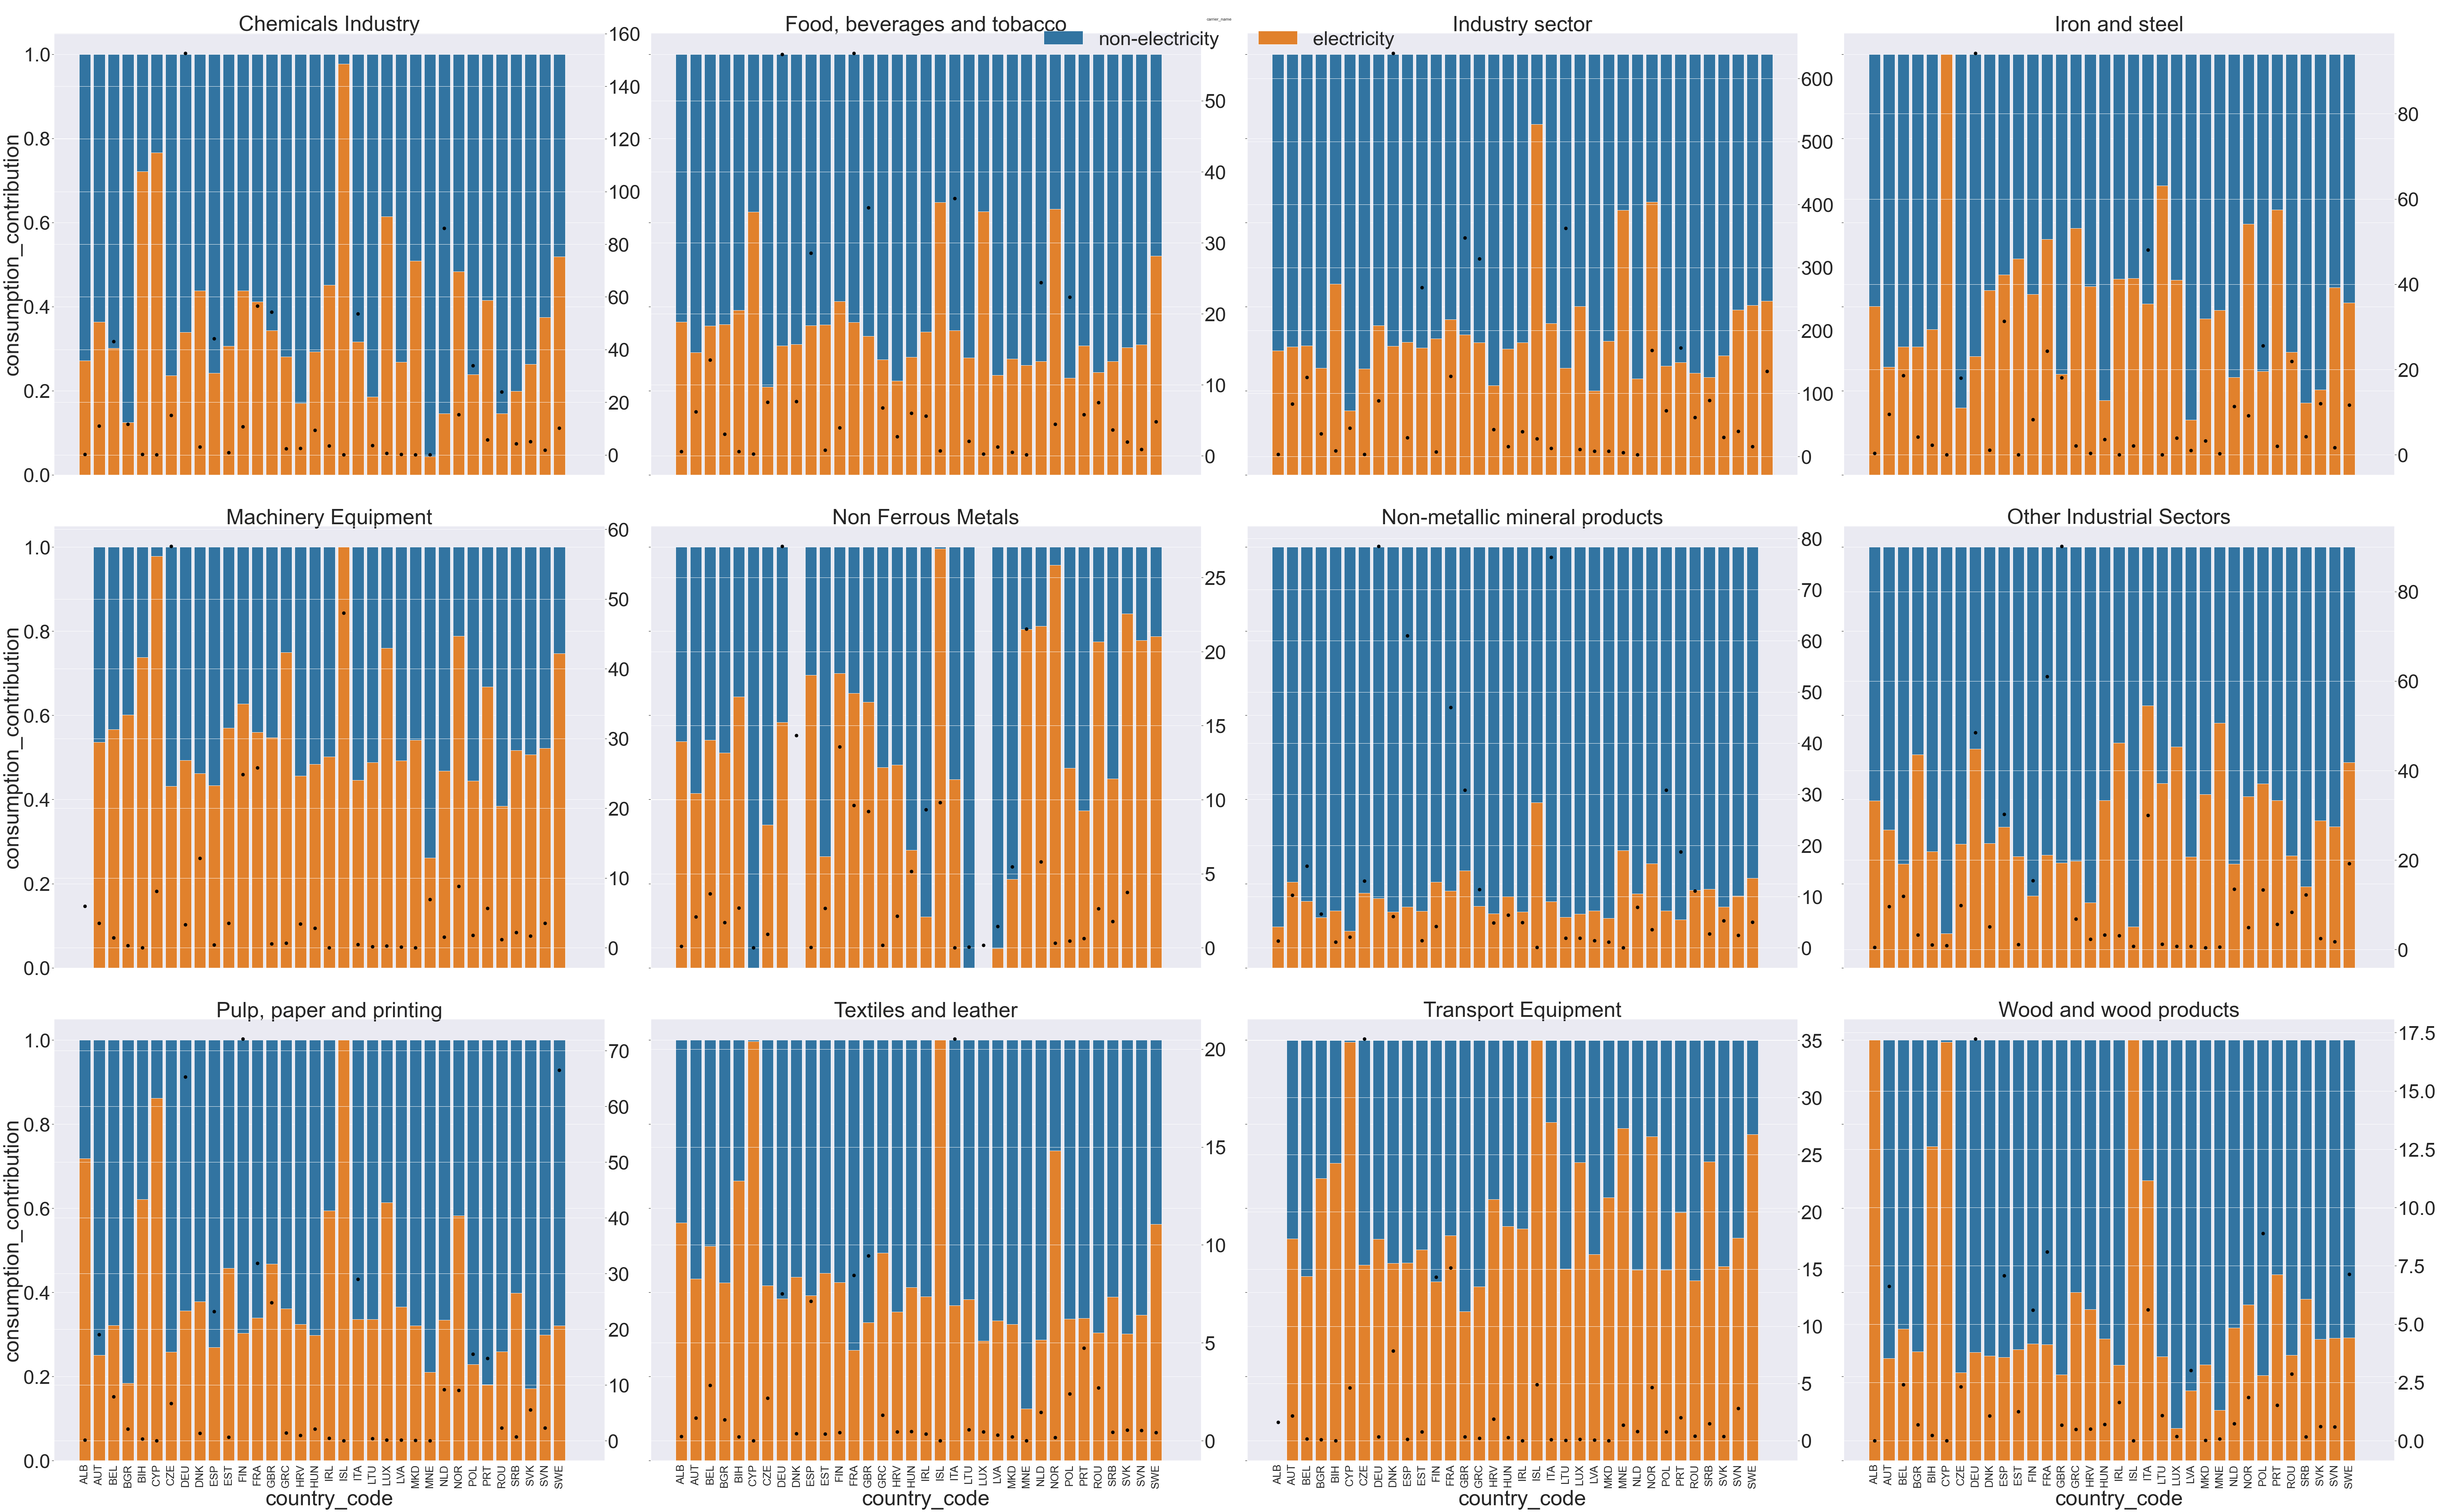

In [6]:
# Plot percentage contribution of electricity and non-electricity consumption to total energy demand in each industry subsector
# for each country seperately, averaged over all years
electricity_in_industry = (
    industry_energy_balances
    .mean(level=['cat_name', 'country_code', 'carrier_name'])
    .unstack()
    .groupby({
        'biofuel': 'non-electricity',
        'heat': 'non-electricity',
        'electricity': 'electricity',
        'manufactured_gas': 'non-electricity',
        'natural_gas': 'non-electricity',
        'oil': 'non-electricity',
        'renewable_heat': 'non-electricity',
        'solid_fuel': 'non-electricity',
    }, axis=1).sum()
)
electricity_in_industry = (
    electricity_in_industry
    .stack()
    .to_frame('consumption')
    .merge(electricity_in_industry
           .div(electricity_in_industry.sum(axis=1), axis=0)
           .cumsum(axis=1)
           .stack()
           .to_frame('consumption_contribution'), 
           left_index=True, right_index=True)
)
with sns.plotting_context("notebook", font_scale=5):
    sns.set_style("darkgrid")
    g = sns.FacetGrid(
        electricity_in_industry
        .fillna(0)
        .reset_index()
        .rename(columns={'level_2': 'carrier_name'}), 
        col="cat_name", 
        hue="carrier_name", 
        hue_order=['non-electricity', 'electricity'], 
        col_wrap=4, aspect=1.2, height=20
    )
    g.map(
        sns.barplot, 'country_code', 'consumption_contribution', 
        order=electricity_in_industry.reset_index().country_code.unique()
    )
    g.add_legend(ncol=2, loc='upper center')#, bbox_to_anchor=(0.5, 0.1))
    g.set_titles(col_template = '{col_name}')
    foo = [ax.set_xticklabels(electricity_in_industry.reset_index().country_code.unique(), rotation=90, ha='center', size=30) for ax in g.axes.flat]
    for ax, (_, subdata) in zip(g.axes, electricity_in_industry.consumption.sum(level=['cat_name', 'country_code']).reset_index().groupby('cat_name')):
        ax2=ax.twinx()
        subdata.plot.scatter(x='country_code', y='consumption', ax=ax2, color='black', legend=False, s=80)
        ax2.set_ylabel('')

In [183]:
JRC_IDEES = JRC_IDEES.xs('ktoe', level='unit').apply(util.ktoe_to_twh)
JRC_IDEES_percent = JRC_IDEES.div(JRC_IDEES.sum(level=['carrier_name', 'cat_name', 'country_code', 'year'])).unstack('year').dropna(how='all').mean(axis=1)
JRC_IDEES_percent_by_country = JRC_IDEES_percent.unstack('country_code')
balkan_countries = JRC_IDEES_percent_by_country[['BGR', 'HRV', 'HUN', 'ROU', 'GRC']].mean(axis=1)
nordic_countries = JRC_IDEES_percent_by_country[['SWE', 'FIN', 'DNK']].mean(axis=1)
JRC_IDEES_percent_by_country = JRC_IDEES_percent_by_country.assign(
    ALB=balkan_countries,
    BIH=balkan_countries,
    MNE=balkan_countries,
    MKD=balkan_countries,
    SRB=balkan_countries,   
    NOR=nordic_countries,
    ISL=nordic_countries
)

mapped_end_uses = (
    JRC_IDEES_percent_by_country.stack()
    .align(industry_energy_balances)[1]
    .mul(JRC_IDEES_percent_by_country.stack())
    .dropna()
)
mapped_end_uses.index = mapped_end_uses.index.remove_unused_levels()
mapped_end_uses = mapped_end_uses.sort_index()

In [184]:
CH_end_use_electricity = (
    published_data
    .xs('CH')
    .xs('electricity', level='carrier_name')
    .sum(level='year')
    .to_frame('CHE')
    .rename_axis(columns='country_code')
    .stack()
    .reorder_levels(['country_code', 'year'])
)
CH_end_use_demand = (
    published_data
    .xs('CH')
    .sum(level=['year', 'end_use'])
    .unstack('end_use')
    .rename(columns={'water_heating': 'process_heating', 'other': 'end_use_electricity', 'space_cooling': 'end_use_electricity'})
    .groupby(level=0, axis=1).sum()
    .stack()
    .to_frame('CHE')
    .rename_axis(columns='country_code')
    .stack()
    .reorder_levels(['country_code', 'year', 'end_use'])
)

In [203]:
mapped_end_use_demand = mapped_end_uses.sum(level=['country_code', 'year', 'end_use']).append(CH_end_use_demand).sort_index()
mapped_end_use_electricity = (
    mapped_end_uses
    .sum(level=['country_code', 'year', 'end_use'])
    .xs('end_use_electricity', level='end_use').add(       
        mapped_end_uses
        .drop('end_use_electricity', level='end_use')
        .sum(level=['country_code', 'year', 'carrier_name'])
        .xs('electricity', level='carrier_name')
    )
    .append(CH_end_use_electricity)
    .sort_index()
)

# fill gaps
mapped_end_use_demand = (
    mapped_end_use_demand
    .unstack(['country_code', 'end_use'])
    .fillna(
        mapped_end_use_demand
        .groupby(['country_code', 'end_use'])
        .agg('first')
    )
    .stack([0, 1])
)
mapped_end_use_electricity = (
    mapped_end_use_electricity.unstack('country_code')
    .fillna(mapped_end_use_electricity.groupby('country_code').agg('first'))
    .stack()
)

 

In [205]:
_df

,country_code,end_use,2018 Energy Demand (TWh)
0,ALB,end_use_electricity,1.058892
1,ALB,process_heating,2.385554
2,ALB,space_heating,2.460452
3,AUT,end_use_electricity,25.291804
4,AUT,process_heating,80.548079
...,...,...,...
100,SVN,process_heating,15.163655
101,SVN,space_heating,15.388814
102,SWE,end_use_electricity,39.880439
103,SWE,process_heating,116.710700


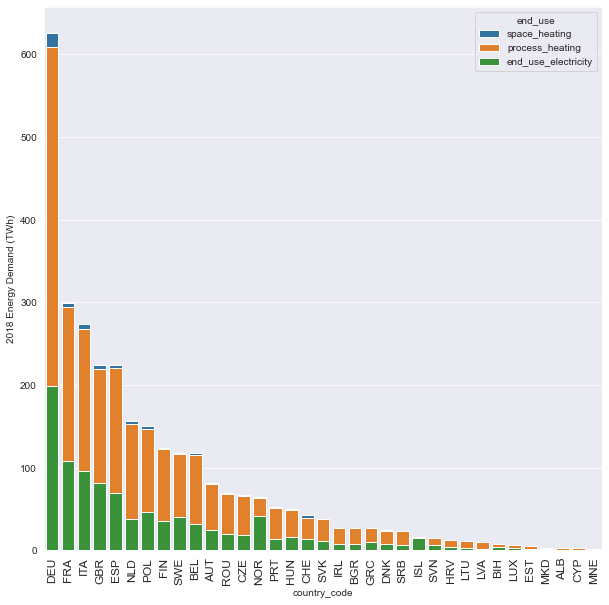

In [204]:
_df = mapped_end_use_demand.xs(2018).unstack().cumsum(axis=1).stack().to_frame('2018 Energy Demand (TWh)').reset_index()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(
    data=_df, 
    x='country_code', 
    y='2018 Energy Demand (TWh)',
    order=mapped_end_use_demand.xs(2018).sum(level='country_code').sort_values(ascending=False).index,
    hue='end_use',
    hue_order=_df.end_use.unique()[::-1],
    dodge=False,
    ax=ax
)
foo = ax.set_xticklabels(mapped_end_use_demand.xs(2018).sum(level='country_code').sort_values(ascending=False).index, rotation=90, ha='center', size=12)

In [212]:
mapped_end_uses.xs('electricity', level='carrier_name').div(mapped_end_uses.sum(level=['cat_name', 'country_code', 'year'])).xs('process_heating', level='end_use').xs('Chemicals Industry').sort_values().unstack()

year,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
country_code,,,,,,,,,,,,,,,,,,,
ALB,0.068228,0.056462,0.046030,0.033905,0.044542,0.055437,0.025883,0.029348,0.041158,0.053654,0.124245,0.154874,0.151090,0.163173,0.174959,0.158164,0.185587,0.154809,0.155307
AUT,0.048727,0.052807,0.052741,0.049004,0.051421,0.050618,0.053193,0.054933,0.053058,0.052063,0.051486,0.052051,0.051980,0.053275,0.055405,0.056717,0.055384,0.053946,0.055170
BEL,0.154088,0.151387,0.150892,0.152364,0.154563,0.149704,0.127636,0.135898,0.133707,0.078173,0.117455,0.120168,0.107254,0.109633,0.109528,0.111850,0.114971,0.128919,0.126738
BGR,0.034527,0.034879,0.035738,0.032094,0.033421,0.034831,0.037902,0.037384,0.037863,0.045610,0.033860,0.029655,0.037184,0.041470,0.040011,0.042285,0.044659,0.044888,0.047762
BIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202871,0.235442,0.223574,0.227158,0.231619
CYP,0.564937,0.564937,0.564937,0.564937,0.564937,0.564937,0.564937,0.564937,0.564937,0.564937,0.564937,0.564937,0.411755,0.564937,0.430296,0.357095,0.366890,0.359042,0.342132
CZE,0.159577,0.174883,0.171223,0.183954,0.152498,0.150318,0.168480,0.168143,0.179676,0.181534,0.160861,0.165485,0.163068,0.160005,0.179550,0.178202,0.181562,0.167270,0.163692
DEU,0.059634,0.062817,0.061722,0.054796,0.056319,0.054406,0.053044,0.048452,0.046641,0.044396,0.047351,0.047339,0.046004,0.045902,0.047870,0.047570,0.046698,0.046608,0.045877
DNK,0.064494,0.062233,0.064999,0.063528,0.067944,0.072425,0.071742,0.072201,0.068032,0.064531,0.061612,0.064302,0.067819,0.067580,0.067348,0.069795,0.069917,0.068351,0.067537


# Map demand to Euro-Calliope subregions

In [69]:
# Get regions
eurospores_units = gpd.read_file('../build/units.geojson')

nuts3_2006 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2006_4326_LEVL_3.geojson')
eurospores_to_nuts3 = pd.read_excel('../data/eurospores.xlsx', sheet_name='locations', index_col='NUTS3')


nuts3_2006 = nuts3_2006[
    (nuts3_2006.bounds.minx >= eurospores_units.total_bounds[0]) &
    (nuts3_2006.bounds.miny >= eurospores_units.total_bounds[1]) &
    (nuts3_2006.bounds.maxx <= eurospores_units.total_bounds[2]) &
    (nuts3_2006.bounds.maxy <= eurospores_units.total_bounds[3]) &
    nuts3_2006.CNTR_CODE.isin(countries.keys())
]
nuts3_2006['nuts2'] = nuts3_2006.id.str[:-1]

In [ ]:
#nuts3_2016 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2016_4326_LEVL_3.geojson')
#nuts2_2006 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2006_4326_LEVL_2.geojson')
#nuts3_2016 = nuts3_2016[
#    (nuts3_2016.bounds.minx >= eurospores_units.total_bounds[0]) &
#    (nuts3_2016.bounds.miny >= eurospores_units.total_bounds[1]) &
#    (nuts3_2016.bounds.maxx <= eurospores_units.total_bounds[2]) &
#    (nuts3_2016.bounds.maxy <= eurospores_units.total_bounds[3]) &
#    nuts3_2016.CNTR_CODE.isin(countries.keys())
#]
#missing_ids = nuts3_2016[~nuts3_2016.id.isin(eurospores_to_nuts3.NUTS3.dropna())]
#nuts3_in_eurospores = gpd.overlay(
#    gpd.GeoDataFrame(data=missing_ids.id, geometry=missing_ids.to_crs('epsg:3035').centroid), 
#    eurospores_units.to_crs('epsg:3035')
#)
#
#nuts3_valid_in_both = (
#    nuts3_2016
#    .set_index('id')
#    .reindex(eurospores_to_nuts3.NUTS3.dropna())
#    .assign(eurospores=eurospores_to_nuts3.NUTS3.dropna().index)
#    .dropna()
#)
#nuts3_with_added_missing_data = (
#    nuts3_valid_in_both['eurospores']
#    .append(nuts3_in_eurospores.set_index('id_1').id_2)
#)
#
#nuts3_2016_eurospores = (
#    nuts3_2016
#    .set_index('id')
#    .loc[nuts3_with_added_missing_data.index]
#    .assign(eurospores=nuts3_with_added_missing_data.values)
#)

In [79]:
# Get data on qantity of freight shipped
freight = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_rl3g.tsv.gz', delimiter='\t', index_col=0)
freight.index = freight.index.str.split(',', expand=True).rename(['subsector', 'unit', 'region'])
freight.columns = freight.columns.astype(int)
freight = freight.apply(util.to_numeric)

freight_sectors = {
    'GT03': 'Mining and quarrying',
    'GT04': 'Food, beverages and tobacco',
    'GT05': 'Textiles and leather',
    'GT06': 'Wood and wood products',
    'GT11': 'Machinery Equipment',
    'GT12': 'Transport Equipment',
    'GT13': 'Other Industrial Sectors'
}
relevant_nuts3 = eurospores_to_nuts3[eurospores_to_nuts3.Source == 'NUTS3'].EuroSPORES
relevant_nuts3.index = relevant_nuts3.index.str.replace('GR', 'EL')
freight_eu = freight.unstack().groupby(freight_sectors, level=0).sum().where(lambda x: x > 0).loc[:, idx[:, relevant_nuts3.index]].stack([0, 1])
freight_eu = freight_eu.to_frame('freight').set_index(freight_eu.index.get_level_values('region').str[:-1], append=True).rename_axis(index=['subsector', 'year', 'nuts3', 'nuts2'])

In [39]:
# Get data on number of employees
industry_activity = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/sbs_r_nuts06_r2.tsv.gz', delimiter='\t', index_col=0)
industry_activity.index = industry_activity.index.str.split(',', expand=True).rename(['cat_code', 'indicator', 'region'])

industrial_activity_codes = pd.read_csv(
    data_path + '/industry/industry_activity_codes.csv', 
    skipfooter=7, index_col=0, header=0, engine='python'
).dropna(subset=['Eurostat sector'])

# V11210 == local units,  V16110 == persons employed,  	V13320 == wages and salaries
industry_employees = industry_activity.xs('V16110', level='indicator').apply(util.to_numeric).loc[industrial_activity_codes['Eurostat sector'].dropna().index]
industry_employees.columns = industry_employees.columns.astype(int)
industry_employees = (
    industry_employees
    .unstack()
    .groupby(industrial_activity_codes['Eurostat sector'].to_dict()).sum(min_count=1)
    .stack([0, 1])
    .rename_axis(index=['subsector', 'year', 'region'])
)

In [82]:
# Combine freight and employee data
freight_employees = pd.concat(
    [freight_eu['freight'].reset_index('nuts3'), 
     industry_employees.reindex(freight_eu.droplevel('nuts3').index).to_frame('employees_nuts2')], 
    axis=1
).set_index('nuts3', append=True)
freight_employees = (
    freight_employees
    .set_index(freight_employees.index.get_level_values('nuts2').str[:2].rename('country_code'), append=True)
    .set_index(freight_employees.index.get_level_values('nuts2').str[:3].rename('nuts1'), append=True)
    .set_index(relevant_nuts3.reindex(freight_employees.index.get_level_values('nuts3')), append=True)
)
freight_employees['employees_nuts1'] = industry_employees.reindex(freight_employees.droplevel(['nuts2', 'nuts3', 'country_code']).index).values
freight_employees['employees_nuts0'] = industry_employees.reindex(freight_employees.droplevel(['nuts2', 'nuts3', 'nuts1']).index).values

# Get contribution of eurospores regions to national industry activity in each subsector
# We do this by going from NUTS2 employment data to NUTS3 by using freight in each subregion
# Then going from NUTS3 up to Euro-Calliope regions
# Where no employment data is available at any spatial resolution (e.g. in Switzerland), freight data is used directly
freight_per_nuts3_nuts2_intensity = freight_employees['freight'].div(freight_employees['freight'].sum(level=['subsector', 'year', 'nuts2']))
freight_per_nuts3_nuts1_intensity = freight_employees['freight'].div(freight_employees['freight'].sum(level=['subsector', 'year', 'nuts1']))
freight_per_nuts3_nuts0_intensity = freight_employees['freight'].div(freight_employees['freight'].sum(level=['subsector', 'year', 'country_code']))
employees_per_nuts3 = (
    freight_employees['employees_nuts2'].mul(freight_per_nuts3_nuts2_intensity)
    .fillna(freight_employees['employees_nuts1'].mul(freight_per_nuts3_nuts1_intensity))
    .fillna(freight_employees['employees_nuts0'].mul(freight_per_nuts3_nuts0_intensity))
)
employees_per_eurospores = employees_per_nuts3.sum(level=['subsector', 'year', 'EuroSPORES', 'country_code'], min_count=1)
freight_per_eurospores = freight_employees['freight'].sum(level=['subsector', 'year', 'EuroSPORES', 'country_code'], min_count=1)
subsector_per_eurospores_national_intensity = (
    employees_per_eurospores.div(employees_per_eurospores.sum(level=['subsector', 'year', 'country_code']))
    .fillna(freight_per_eurospores.div(freight_per_eurospores.sum(level=['subsector', 'year', 'country_code'])))
)

# Restructure for plotting
subsector_employee_freight_intensity = (
    subsector_per_eurospores_national_intensity
    .unstack('subsector')
    .xs(2014)
    .droplevel('country_code')
)

Text(0.5, 0, 'Ratio of subsectoral regional contribution in all years that are not 2014 with data for 2014')

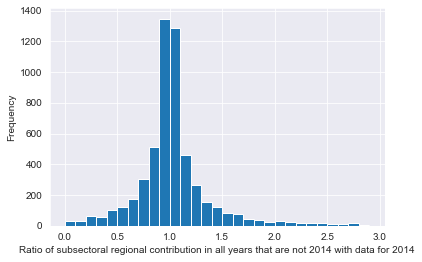

In [201]:
# We will use 2014 data, but we check here that it's vaguely OK to do so (i.e. is 2014 data representative of all other years)
ax = subsector_per_eurospores_national_intensity.unstack('year').div(
    subsector_per_eurospores_national_intensity.xs(2014, level='year'), axis=0
).drop(2014, axis=1).stack().hist(bins=[i/10 for i in range(30)])
ax.set_ylabel('Frequency')
ax.set_xlabel('Ratio of subsectoral regional contribution in all years that are not 2014 with data for 2014')

In [ ]:
# Get emissions data
emissions = gpd.read_file('../build/all_industrial_ets_eprtr_sites.geojson')
# Map industries to Euro-calliope regions
emissions_eu = gpd.overlay(emissions, eurospores_units)

emissions_intensity_eu = (
    emissions_eu
    .groupby(['id', 'Subsector', 'country_code']).sum()
    .apply(lambda x: x / x.sum(level=['Subsector', 'country_code']))
    .reset_index('country_code', drop=True)
    .emissions
    .drop('Other Industrial Sectors')
    .unstack(0)
)

In [ ]:
# Combine freight/employee subsector intensities with emissions subsector intensities
eurospores_industry_intensity = (
    eurospores_units
    .merge(emissions_intensity_eu, left_on='id', right_index=True, how='outer')
    .merge(subsector_employee_freight_intensity, left_on='id', right_index=True, how='outer')
    .fillna(0).to_crs('epsg:3035')
)

subsectors = eurospores_industry_intensity.columns.difference(eurospores_units.columns)
eurospores_industry_intensity.loc[eurospores_industry_intensity['type'] == 'country', subsectors] = 1

In [ ]:
national_units = eurospores_units_emissions.dissolve('country_code').simplify(10000)  # takes a minute, so it's better to run independently

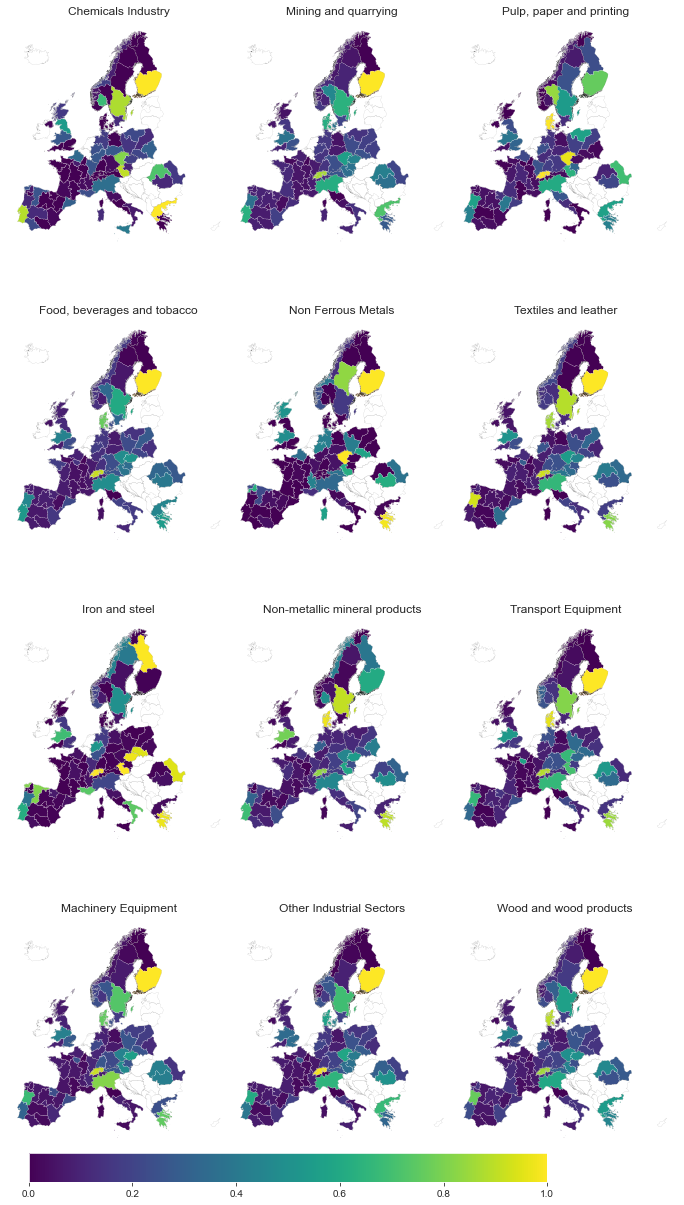

In [200]:
fig, ax = plt.subplots(4, 3, figsize=(12, 20), gridspec_kw={"wspace": 0, "hspace": 0})
_ax1 = 0
_ax2 = 0
for subsector in subsectors:
    if _ax1 > 3:
        _ax1 = 0
        _ax2 += 1
    ax[_ax1, _ax2].axis('off')
    eurospores_industry_intensity[eurospores_industry_intensity['type'] != 'country'].plot(
        subsector, cmap='viridis', edgecolor='white', linewidth=0.1, ax=ax[_ax1, _ax2], vmin=0, vmax=1
    )
    ax[_ax1, _ax2].set_title(subsector)
    national_units.plot(facecolor='None', edgecolor='black', linewidth=0.05, ax=ax[_ax1, _ax2])
    _ax1 += 1
    
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.15, 0.05, 0.6, 0.02])
fig.colorbar(mappable=ax[0, 0].collections[0], cax=cbar_ax, orientation='horizontal')


In [187]:
# Go from regional contributions to regional energy consumption
eurospores_industry_intensity_df = eurospores_industry_intensity.set_index(['id', 'country_code'])[subsectors].rename_axis(columns='cat_name').stack()
aligned_dfs = industry_energy_balances.align(eurospores_industry_intensity_df)
eurospores_industry_energy_df = aligned_dfs[0].mul(aligned_dfs[1]).where(lambda x: x > 0).dropna()